#Food Classification -

## Loading Relevant Libraries -

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import keras
import os
import shutil, sys 
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers.pooling import AveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.metrics import top_k_categorical_accuracy

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Loading -

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
!ls
os.chdir('/content/drive/My Drive/Projects/HealthRX Computer Vision/')
!ls

In [ ]:
'''path='/content/drive/My Drive/Projects/HealthRX Computer Vision/Data'
newpath='/content/drive/My Drive/Projects/HealthRX Computer Vision/newtest'
cat=os.listdir(path)
#os.mkdir(newpath)
for i in cat:
    src=path+'/'+i
    dest=newpath+'/'+i
    #os.mkdir(dest)
    imgs=os.listdir(src)
    num=len(imgs)
    #count=0
    #print(i,'->',num,'Images')
    count=0
    for f in imgs:
        if count<(num):
            finalsrc=src+'/'+f
            finaldest=dest+'/'+f
            shutil.move(finalsrc,dest)
        else:
            break
        count=count+1'''

## Dataset Visualization -

In [ ]:
trainpath='/content/drive/My Drive/Projects/HealthRX Computer Vision/Data'
testpath='/content/drive/My Drive/Projects/HealthRX Computer Vision/test'
cat=os.listdir(trainpath)
names=[]
train=[]
test=[]
for i in cat:
    src=trainpath+'/'+i
    dest=testpath+'/'+i
    imgs=os.listdir(src)
    imgs2=os.listdir(dest)
    trnum=len(imgs)
    tenum=len(imgs2)
    names.append(i)
    train.append(trnum)
    test.append(tenum)

In [ ]:
z=np.array([train,test])

z=np.transpose(z)
details=pd.DataFrame(z,columns=['Training Data','Testing Data'],index=names)

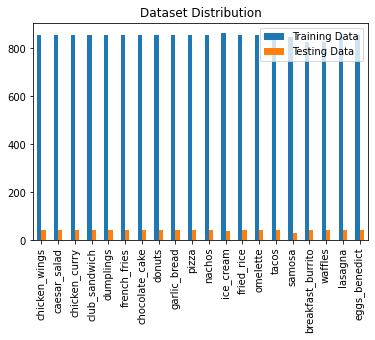

In [ ]:
details.plot.bar(rot=90, title="Dataset Distribution")
#plt.savefig('DatasetDistribution.png')

## Model Definition -

In [ ]:
#Create Training and Validation Sets from Training Data
path = '/content/drive/My Drive/Projects/HealthRX Computer Vision/Data' #Specify Path here
dg=ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.15,rescale=1./255,horizontal_flip=True,validation_split=0.2)
training=dg.flow_from_directory(directory=path,target_size=(128,128),class_mode="categorical", batch_size=128,shuffle=True,subset='training')
validate=dg.flow_from_directory(directory=path,target_size=(128,128),class_mode="categorical", batch_size=128,shuffle=True,subset='validation')

Found 13698 images belonging to 20 classes.
Found 3422 images belonging to 20 classes.


In [ ]:
#Importing VGG16 model with ImageNet weights
baseModel=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(128,128,3)))
#baseModel.summary()

In [ ]:
#Creating the Latter Layers For Training -
endModel = baseModel.output
endModel = AveragePooling2D(pool_size=(4, 4))(endModel)
endModel = Flatten(name="flatten")(endModel)
endModel = Dense(128,activation="relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4))(endModel)
endModel = Dropout(0.2)(endModel)
endModel = Dense(64,activation="relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4))(endModel)
endModel = Dropout(0.2)(endModel)
endModel = Dense(20, activation="softmax")(endModel)

#Making Only Last 4 Layers of VGG16 as Trainable -
number=len(baseModel.layers)
print(number)
model=Model(inputs=baseModel.input,outputs=endModel)
model2=model
count=0
for layer in baseModel.layers :
  if(count<(number-8)):
    layer.trainable=False
  count=count+1

19


In [ ]:
#Final Model Metrics and Architecture -
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss="categorical_crossentropy",metrics=[keras.metrics.categorical_accuracy])
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0  

## Training

In [ ]:
'''from keras.utils import plot_model
plot_model(model, to_file='model.png',show_layer_names=False,show_shapes=True)'''

"from keras.utils import plot_model\nplot_model(model, to_file='model.png',show_layer_names=False,show_shapes=True)"

In [ ]:
#Find Step Sizes (Needed for Training) -
STEP_SIZE_TRAIN=training.n//training.batch_size
STEP_SIZE_VALID=validate.n//validate.batch_size

In [ ]:
#Train Model -
early = EarlyStopping(monitor = 'val_categorical_accuracy',verbose=1,patience = 3)
history = model.fit_generator(training,steps_per_epoch = STEP_SIZE_TRAIN,validation_data = validate,validation_steps = STEP_SIZE_VALID,epochs =100,callbacks= [early])

In [ ]:
model.save('trainedmodell4.h5')

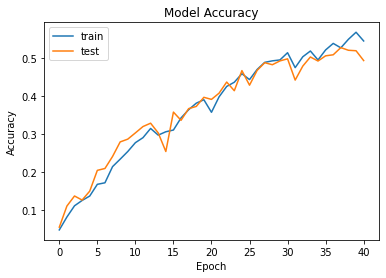

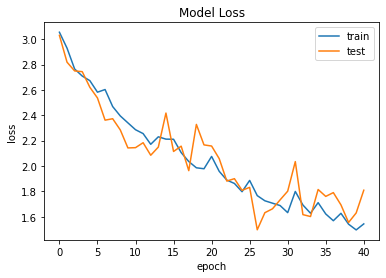

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy.png')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('loss.png')

## Testing

In [ ]:
bestmodel=load_model('/content/drive/My Drive/Projects/HealthRX Computer Vision/bestmodel.h5')

In [ ]:
testdatapath='/content/drive/My Drive/Projects/HealthRX Computer Vision/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(directory=testdatapath,target_size=(128,128),class_mode=None,batch_size=1,shuffle=False) 

Found 879 images belonging to 20 classes.


In [ ]:
num=879 #Number of Data Samples (Recieve from O/P of previous cell)
predict = bestmodel.predict_generator(test_generator,steps=num,verbose=1)

879/879 [==============================] - 6s 7ms/step


In [ ]:
#Confusion Matrix -
y_pred = np.argmax(predict, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

Confusion Matrix
[[ 1  0  1  1  2  3  5  0  4  2  1  1  4  1  2  6  1  3  2  5]
 [ 0 26  0  0  2 10  0  0  0  0  2  0  0  0  0  1  0  0  4  0]
 [ 0  0 23  6  2  2  2  0  0  0  0  1  3  2  0  1  0  0  2  1]
 [ 0  0  3 27  1  1  3  0  0  4  0  0  2  1  0  0  0  1  0  2]
 [ 0  0  1  0 39  0  1  0  0  0  0  0  2  1  0  0  1  0  0  0]
 [ 0  0  0  0  3 28  1  0  1  7  0  0  1  0  0  0  0  0  2  2]
 [ 0  0  0  1  6  0 27  0  0  0  0  0  5  0  0  0  1  3  0  2]
 [ 0  0  0  0  1  0  3 26  1  1  0  1  8  0  0  0  0  3  0  1]
 [ 0  1  0  0  1  0  0  0 34  1  0  2  1  1  1  2  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0 37  0  0  3  0  1  0  0  0  0  3]
 [ 1  1  1  1  2  1  1  0  0  0 30  0  2  1  0  1  0  0  2  1]
 [ 0  0  0  0  1  0  0  0  1  2  1 29  5  1  0  2  1  1  1  0]
 [ 3  0  1  0 12  0  5  0  0  0  0  0 10  0  2  0  0  0  1  3]
 [ 1  0  5  0  1  0  1  0  1  0  2  2  1 18  0  5  5  0  0  3]
 [ 0  2  2  1  2  1  4  0  0  1  2  0  1  2  8  1  6  0  7  5]
 [ 1  0  3  0  1  3  1  0  1  0  2  6 

In [ ]:
#Classification Report -
print(classification_report(test_generator.classes, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.100     0.022     0.036        45
           1      0.634     0.578     0.605        45
           2      0.489     0.511     0.500        45
           3      0.711     0.600     0.651        45
           4      0.476     0.867     0.614        45
           5      0.500     0.622     0.554        45
           6      0.443     0.600     0.509        45
           7      1.000     0.578     0.732        45
           8      0.756     0.756     0.756        45
           9      0.649     0.822     0.725        45
          10      0.698     0.667     0.682        45
          11      0.674     0.644     0.659        45
          12      0.169     0.270     0.208        37
          13      0.429     0.400     0.414        45
          14      0.471     0.178     0.258        45
          15      0.410     0.356     0.381        45
          16      0.515     0.378     0.436        45
          17      0.485    

### Top 5 Accuracy Calculation (Primary Metric)

In [ ]:
#True One-hot labelling -
true=[]
for j in test_generator.classes:
  temp=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  temp[j]=1.0
  true.append(temp)

In [ ]:
#Predicted Probabilities -
pre=predict.tolist()

In [ ]:
top_k_accuracy=5
output=top_k_categorical_accuracy(true,pre,k=top_k_accuracy)
#print(output)
correct=0
for x in output:
  if x==1:
    correct=correct+1

print('Top',top_k_accuracy,'Accuracy =',correct/879*100,'%')

Top 5 Accuracy = 82.0250284414107 %


In [ ]:
preds_cls_idx = predict.argmax(axis=-1)
idx_to_cls = {v: k for k, v in training.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
filenames_to_cls = list(zip(test_generator.filenames, preds_cls))
ans=preds_cls #NumPy Array with obtained classification results

In [ ]:
result=pd.DataFrame(data=filenames_to_cls,columns=['Actual','Predicted'])
result.head()

,Actual,Predicted
0,breakfast_burrito/1282390.jpg,eggs_benedict
1,breakfast_burrito/129332.jpg,eggs_benedict
2,breakfast_burrito/143832.jpg,waffles
3,breakfast_burrito/1543815.jpg,waffles
4,breakfast_burrito/1563896.jpg,chicken_curry


In [ ]:
#Saving Results -
#result.to_csv('Results.csv')

## Visualizing Augmentations

Augmentations Used  -


*   Width Shift
*   Height Shift
*   Horizontal Flip
*   Rotation



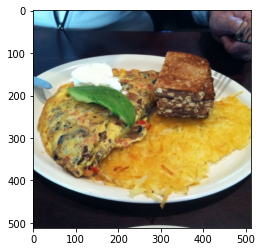

In [ ]:
img = load_img('/content/drive/My Drive/Projects/HealthRX Computer Vision/test/omelette/2055627.jpg')
pyplot.imshow(img)
#plt.savefig('original.png')

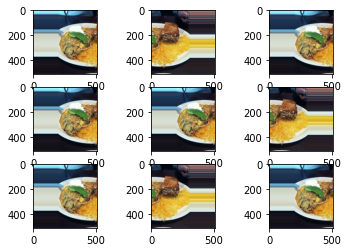

<Figure size 432x288 with 0 Axes>

In [ ]:
data = img_to_array(img)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(width_shift_range=[-200,200])
it = datagen.flow(samples, batch_size=1)
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	pyplot.imshow(image)
pyplot.show()
#plt.savefig('WidthShift.png')

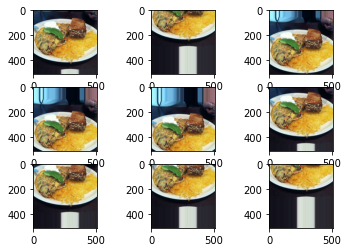

<Figure size 432x288 with 0 Axes>

In [ ]:
datagen = ImageDataGenerator(height_shift_range=0.5)
it = datagen.flow(samples, batch_size=1)
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	pyplot.imshow(image)
pyplot.show()
#plt.savefig('HeightShift.png')

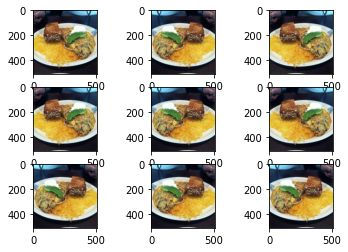

<Figure size 432x288 with 0 Axes>

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True)
it = datagen.flow(samples, batch_size=1)
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	pyplot.imshow(image)
pyplot.show()
#plt.savefig('HorizontalFlip.png')

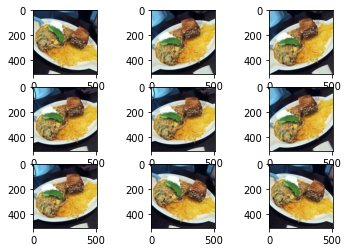

<Figure size 432x288 with 0 Axes>

In [ ]:
datagen = ImageDataGenerator(rotation_range=30)
it = datagen.flow(samples, batch_size=1)
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	pyplot.imshow(image)
pyplot.show()
#plt.savefig('Rotation.png')